# Import libraries

In [2]:
import gc

In [3]:
gc.collect()

633

In [4]:
#Import dependencies
import numpy as np
import pandas as pd 
import seaborn as sns
import os as os
import matplotlib.pyplot as plt
import calendar

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate

# Import dataframes

In [5]:
# Load the data
df = pd.read_csv('input/cybersecurity_attacks.csv')
print("Data loaded successfully")
df.head()

Data loaded successfully


,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,...,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,...,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,...,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,...,Blocked,Medium,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,"Jaunpur, Rajasthan",NaN,NaN,Alert Data,Firewall
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,...,Blocked,Low,Dhanush Chad,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,"Anantapur, Tripura",149.6.110.119,NaN,Alert Data,Firewall


# Info on the dataframes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Timestamp               40000 non-null  object 
 1   Source IP Address       40000 non-null  object 
 2   Destination IP Address  40000 non-null  object 
 3   Source Port             40000 non-null  int64  
 4   Destination Port        40000 non-null  int64  
 5   Protocol                40000 non-null  object 
 6   Packet Length           40000 non-null  int64  
 7   Packet Type             40000 non-null  object 
 8   Traffic Type            40000 non-null  object 
 9   Payload Data            40000 non-null  object 
 10  Malware Indicators      20000 non-null  object 
 11  Anomaly Scores          40000 non-null  float64
 12  Alerts/Warnings         19933 non-null  object 
 13  Attack Type             40000 non-null  object 
 14  Attack Signature        40000 non-null

In [7]:
print(df.shape)

(40000, 25)


In [8]:
df.columns


Index(['Timestamp', 'Source IP Address', 'Destination IP Address',
       'Source Port', 'Destination Port', 'Protocol', 'Packet Length',
       'Packet Type', 'Traffic Type', 'Payload Data', 'Malware Indicators',
       'Anomaly Scores', 'Alerts/Warnings', 'Attack Type', 'Attack Signature',
       'Action Taken', 'Severity Level', 'User Information',
       'Device Information', 'Network Segment', 'Geo-location Data',
       'Proxy Information', 'Firewall Logs', 'IDS/IPS Alerts', 'Log Source'],
      dtype='object')

9826


/var/folders/ms/lx6k291d71z8f387pwx9g8cm0000gn/T/ipykernel_11763/2068220801.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summed_counts = value_counts.groupby(pd.cut(value_counts.index, bins=range(0, 10001, 500))).sum()


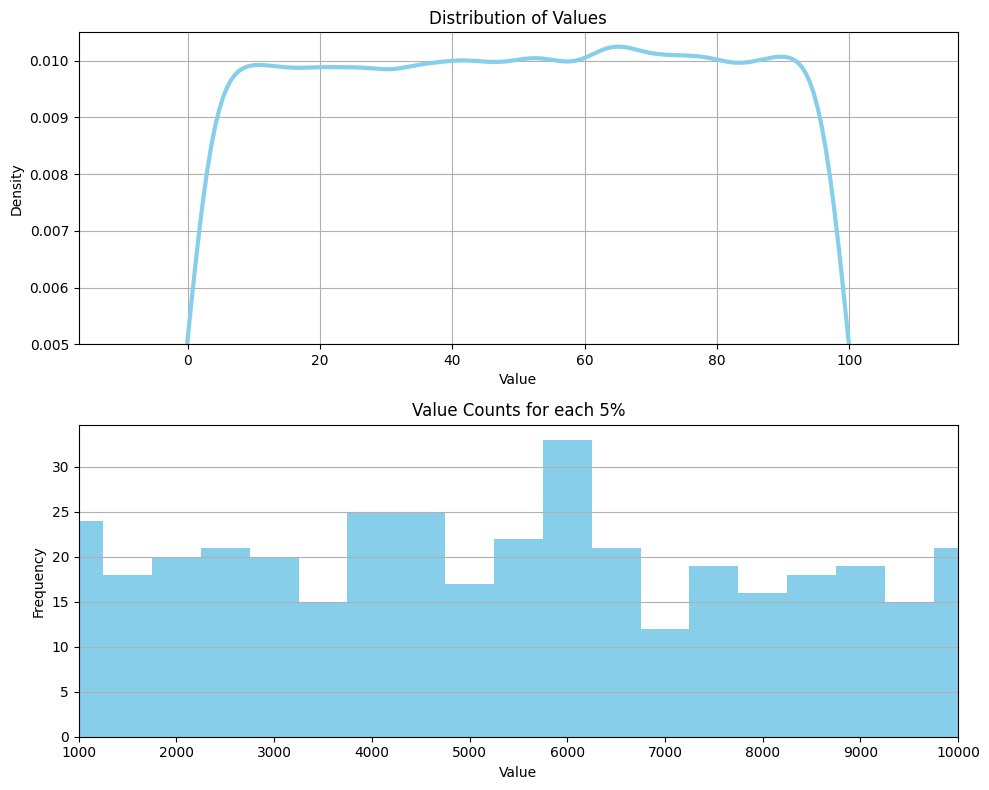

(0, 500]         26
(500, 1000]      24
(1000, 1500]     18
(1500, 2000]     20
(2000, 2500]     21
(2500, 3000]     20
(3000, 3500]     15
(3500, 4000]     25
(4000, 4500]     25
(4500, 5000]     17
(5000, 5500]     22
(5500, 6000]     33
(6000, 6500]     21
(6500, 7000]     12
(7000, 7500]     19
(7500, 8000]     16
(8000, 8500]     18
(8500, 9000]     19
(9000, 9500]     15
(9500, 10000]    21
Name: count, dtype: int64


In [9]:
print(len(sorted(np.unique(df['Anomaly Scores']))))

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

sns.kdeplot(df['Anomaly Scores'], color='skyblue', linewidth=3, ax=ax[0])
ax[0].set_title('Distribution of Values')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Density')
ax[0].set_ylim(0.005,0.0105)
ax[0].grid(True)

value_counts = df['Anomaly Scores'].value_counts().sort_index().reindex(range(101), fill_value=0)
value_counts.index *= 100
summed_counts = value_counts.groupby(pd.cut(value_counts.index, bins=range(0, 10001, 500))).sum()

ax[1].bar([interval.right for interval in summed_counts.index], summed_counts.values, color='skyblue', width=500)
ax[1].set_title('Value Counts for each 5%')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Frequency')
ax[1].grid(axis='y')
ax[1].set_xlim(1000,10000)

plt.tight_layout()

plt.show()

print(summed_counts)

# Preprocessing

In [216]:
print(f'{len(df)} -> {len(df.dropna())}')

40000 -> 1237


In [217]:
df.isnull().sum()

Timestamp                     0
Source IP Address             0
Destination IP Address        0
Source Port                   0
Destination Port              0
Protocol                      0
Packet Length                 0
Packet Type                   0
Traffic Type                  0
Payload Data                  0
Malware Indicators        20000
Anomaly Scores                0
Alerts/Warnings           20067
Attack Type                   0
Attack Signature              0
Action Taken                  0
Severity Level                0
User Information              0
Device Information            0
Network Segment               0
Geo-location Data             0
Proxy Information         19851
Firewall Logs             19961
IDS/IPS Alerts            20050
Log Source                    0
dtype: int64

In [10]:
def plot_correlation(df,f_column):
    fig, ax = plt.subplots(1, 2, figsize=(14, 8))
    sns.boxplot(x=f_column, y='Anomaly Scores', data=df, ax=ax[0])
    ax[0].set_title(f'Effect of {f_column} on Anomaly Scores (Box Plot)')
    ax[0].grid(True)

    sns.violinplot(x=f_column, y='Anomaly Scores', data=df,ax=ax[1])
    ax[1].set_title(f'Effect of {f_column} on Anomaly Scores(Violin Plot)')
    ax[1].grid(True)
    plt.show()

In [11]:
print(df['Malware Indicators'].astype(str).unique())
print(df['Malware Indicators'].value_counts())


['IoC Detected' 'nan']
Malware Indicators
IoC Detected    20000
Name: count, dtype: int64


In [12]:
print(df['Alerts/Warnings'].astype(str).unique())
print(df['Alerts/Warnings'].value_counts())

['nan' 'Alert Triggered']
Alerts/Warnings
Alert Triggered    19933
Name: count, dtype: int64


In [13]:
print(df['Proxy Information'].astype(str).unique())
print(df['Proxy Information'].value_counts().sort_values())

['150.9.97.135' 'nan' '114.133.48.179' ... '60.51.30.46' '137.76.130.8'
 '112.169.115.139']
Proxy Information
19.94.186.159     1
59.131.15.72      1
155.121.88.187    1
20.252.145.34     1
65.202.47.241     1
                 ..
181.0.25.7        1
155.203.171.1     1
29.52.138.22      1
119.168.222.36    1
39.123.165.122    2
Name: count, Length: 20148, dtype: int64


In [14]:
print(df['Firewall Logs'].astype(str).unique())
print(df['Firewall Logs'].value_counts())

['Log Data' 'nan']
Firewall Logs
Log Data    20039
Name: count, dtype: int64


In [15]:
print(df['IDS/IPS Alerts'].astype(str).unique())
print(df['IDS/IPS Alerts'].value_counts())

['nan' 'Alert Data']
IDS/IPS Alerts
Alert Data    19950
Name: count, dtype: int64


In [23]:
df['Malware Indicators'].replace('IoC Detected', 1, inplace=True)
df['Malware Indicators'].fillna(0, inplace=True)

df['Alerts/Warnings'].replace('Alert Triggered', 1, inplace=True)
df['Alerts/Warnings'].fillna(0, inplace=True)

df['Proxy Information'].fillna(0, inplace=True)
#df[df['Proxy Information']!=0]['Proxy Information']=1
df.loc[df['Proxy Information'] != 0, 'Proxy Information'] = 1

df['Firewall Logs'].replace('Log Data', 1, inplace=True)
df['Firewall Logs'].fillna(0, inplace=True)

df['IDS/IPS Alerts'].replace('Alert Data', 1, inplace=True)
df['IDS/IPS Alerts'].fillna(0, inplace=True)

/var/folders/ms/lx6k291d71z8f387pwx9g8cm0000gn/T/ipykernel_11763/2667704823.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Malware Indicators'].replace('IoC Detected', 1, inplace=True)
/var/folders/ms/lx6k291d71z8f387pwx9g8cm0000gn/T/ipykernel_11763/2667704823.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are se

In [24]:
df['Proxy Information']

0        1
1        0
2        1
3        0
4        1
        ..
39995    0
39996    1
39997    0
39998    1
39999    1
Name: Proxy Information, Length: 40000, dtype: object

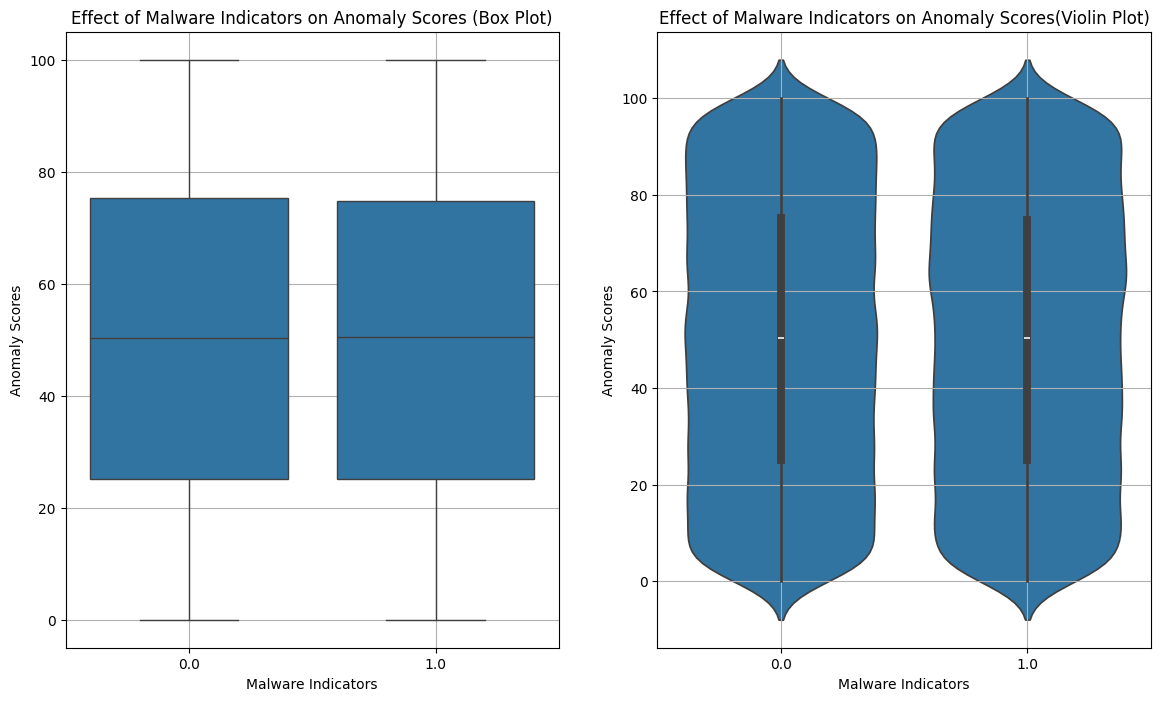

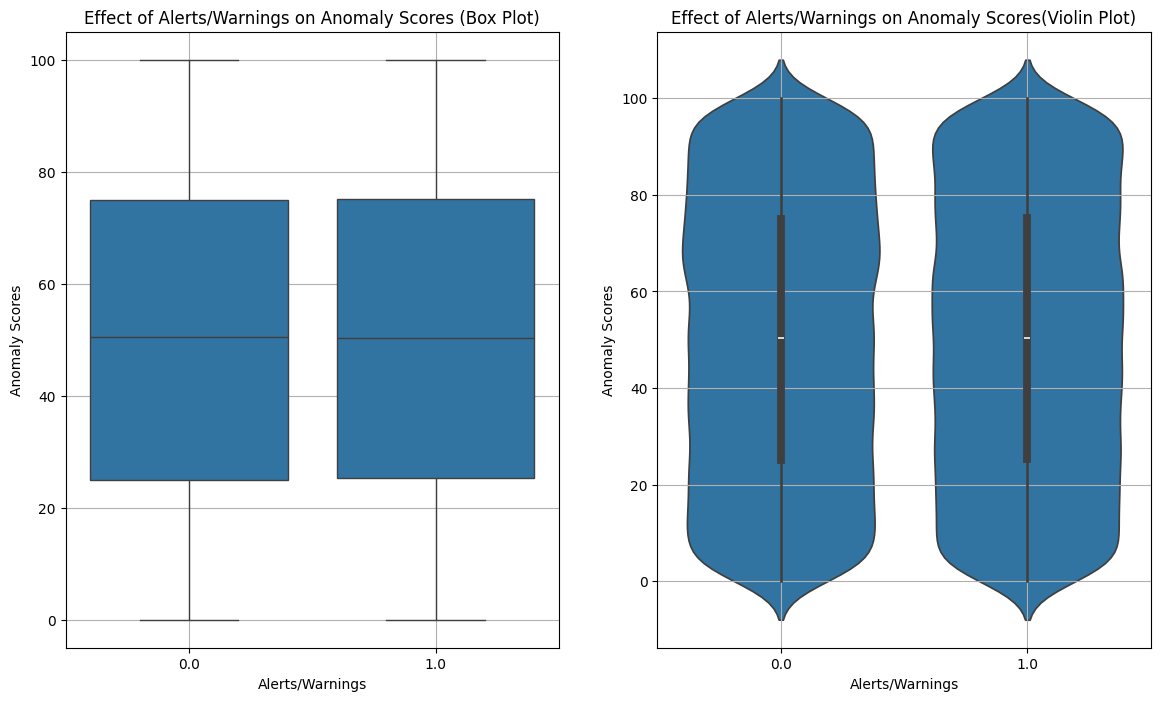

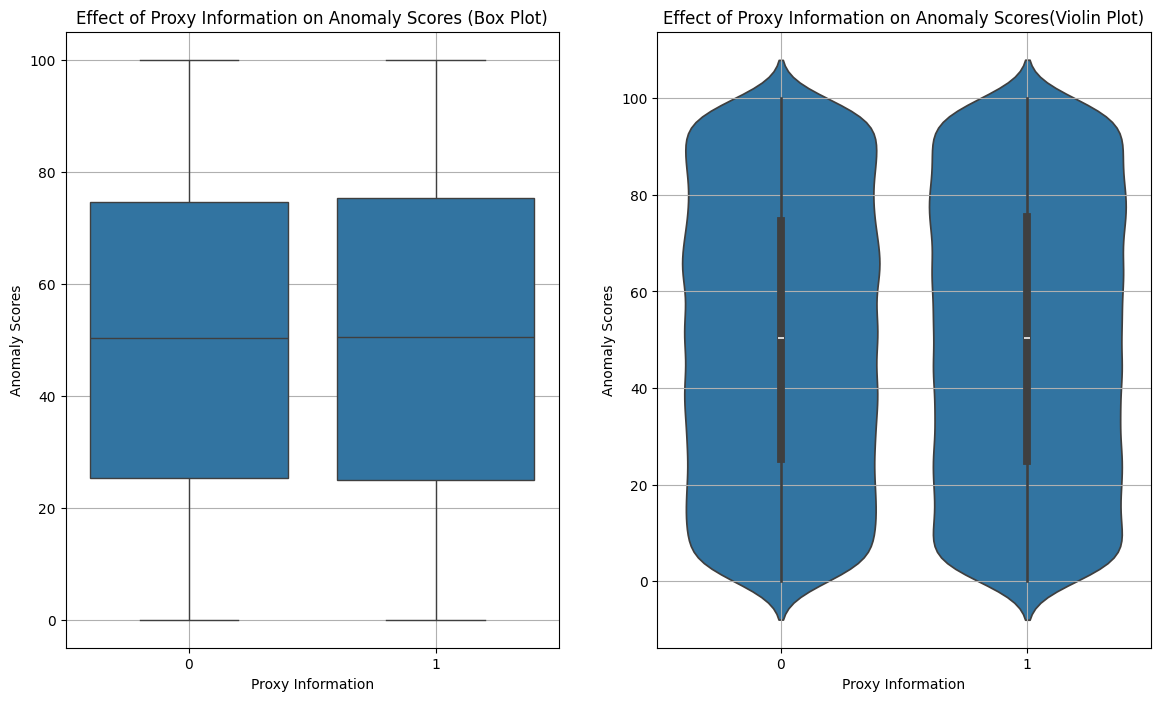

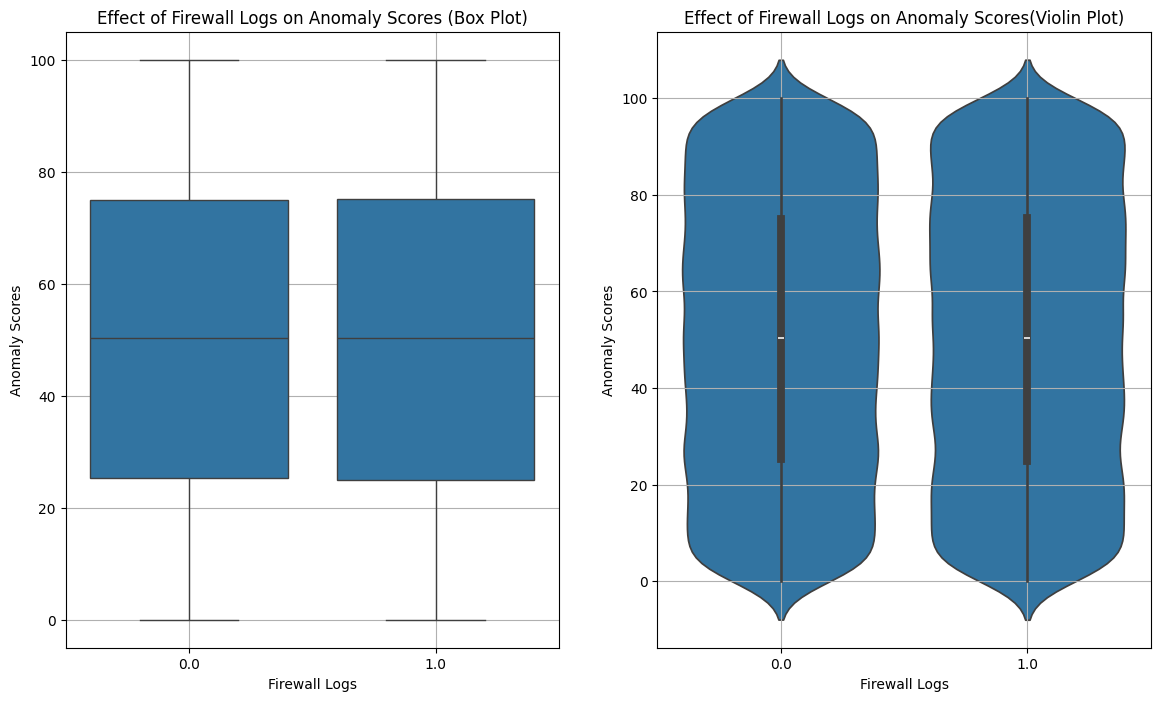

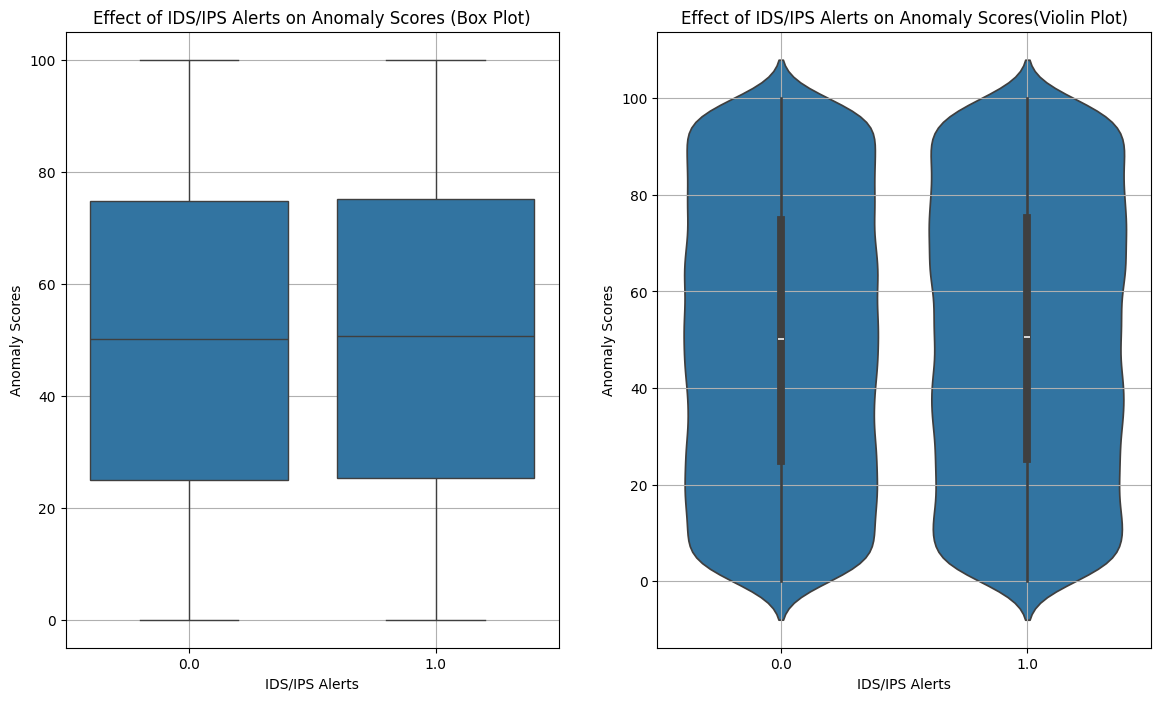

In [25]:
plot_correlation(df,'Malware Indicators')
plot_correlation(df,'Alerts/Warnings')
plot_correlation(df,'Proxy Information')
plot_correlation(df,'Firewall Logs')
plot_correlation(df,'IDS/IPS Alerts')

In [9]:
df_clean = df.dropna().copy()
df_clean.loc[:, 'Date'] = pd.to_datetime(df_clean['Timestamp'])


In [8]:
df_processed = df_clean.copy()
encoder = LabelEncoder()
df_processed['Source IP Address Encoded'] = encoder.fit_transform(df_processed['Source IP Address'])
df_processed['Destination IP Address Encoded'] = encoder.fit_transform(df_processed['Destination IP Address'])

# Display the processed df's first rows to verify changes
df_processed.head(2)



,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source,Date,Source IP Address Encoded,Destination IP Address Encoded
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,...,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,2022-11-13 08:23:25,1007,592
7,2023-02-12 07:13:17,11.48.99.245,178.157.14.116,34489,20396,ICMP,1022,Data,DNS,Amet libero optio quidem praesentium libero. E...,...,Mozilla/5.0 (Macintosh; U; PPC Mac OS X 10_7_6...,Segment A,"Phagwara, Andhra Pradesh",192.31.159.5,Log Data,Alert Data,Firewall,2023-02-12 07:13:17,84,467


# Model

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestRegressor

In [10]:
categorical_features = ['Protocol', 'Packet Type', 'Traffic Type', 'Malware Indicators',
                         'Attack Type', 'Attack Signature', 'Action Taken', 'Network Segment', 'Alerts/Warnings','Severity Level']

numerical_features = ['Packet Length']

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

X= df [categorical_features + numerical_features]
y= df['Anomaly Scores']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor) , ('model', RandomForestRegressor(n_estimators=100))
])

In [11]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Protocol', 'Packet Type',
                                                   'Traffic Type',
                                                   'Malware Indicators',
                                                   'Attack Type',
                                                   'Attack Signature',
                                                   'Action Taken',
                                                   'Network Segment',
                                                   'Alerts/Warnings',
                                                   'Severity Level']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Packet Length'])])),
                ('model', RandomForestRegressor())])

In [12]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Protocol', 'Packet Type',
                                                   'Traffic Type',
                                                   'Malware Indicators',
                                                   'Attack Type',
                                                   'Attack Signature',
                                                   'Action Taken',
                                                   'Network Segment',
                                                   'Alerts/Warnings',
                                                   'Severity Level']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Packet Length'])])),
                ('model', RandomForestRegressor())])

In [24]:
pipeline.feature_names_in_

array(['Protocol', 'Packet Type', 'Traffic Type', 'Malware Indicators',
       'Attack Type', 'Attack Signature', 'Action Taken',
       'Network Segment', 'Alerts/Warnings', 'Severity Level',
       'Packet Length'], dtype=object)

In [25]:
cross_validate(pipeline, X_train, y_train, cv=5, scoring='r2', return_train_score=True)

{'fit_time': array([14.10059857, 14.18230581, 13.73164701, 14.09175277, 14.15823817]),
 'score_time': array([0.17366171, 0.18626451, 0.18288493, 0.17806149, 0.17203617]),
 'test_score': array([-0.06892174, -0.06558292, -0.06908311, -0.05680563, -0.05116809]),
 'train_score': array([0.85011586, 0.85013906, 0.85127379, 0.84980831, 0.85032529])}

# Visualizations

In [19]:
df = pd.read_csv('input/cybersecurity_attacks.csv', usecols=['Timestamp', 'Protocol', 'Packet Type',
                                                       'Traffic Type', 'Anomaly Scores','Attack Type','Severity Level'], parse_dates=['Timestamp'])

#Columns are then renamed to lowercase strings
df.columns = ['date',  'Protocol', 'Packet Type','Traffic Type','Anomaly Scores','Attack Type','Severity Level' ]

# create columns that extracted from day for pivot purpose
df['month'] = df.date.dt.month
df['year'] = df.date.dt.year
df['day'] = df.date.dt.day
df['weekdayName'] = df.date.dt.day_name() # df.date.dt.day_name()
df['weekday'] = df.date.dt.weekday
df['weekend'] = df.date.dt.weekday // 5 == 1


# Pivot table to display year 2020...2023 vs months
# aggfunc is count to show attack count on certain month in each year
all_month_year_df = pd.pivot_table(df, values='Attack Type',
                                   index=["month"],
                                   columns=["year"],
                                   fill_value=0,                                   
                                   aggfunc="count"
                                   )
named_index = [[calendar.month_abbr[i] if isinstance(i, int) else i for i in list(all_month_year_df.index)]] # name months
all_month_year_df = all_month_year_df.set_index(named_index)
all_month_year_df


year,2020,2021,2022,2023
Jan,814,858,883,823
Feb,830,788,807,807
Mar,906,902,925,945
Apr,825,865,884,847
May,904,874,909,908
Jun,889,929,928,863
Jul,880,904,950,889
Aug,904,898,905,908
Sep,877,909,843,853
Oct,905,891,897,296


In [18]:
# visualize only year 2023 by month
# grouping by year first
grouped2023 = df.groupby(['year'])
df2023 = grouped2023.get_group(2023) # jan 2023 ?
df2023 = df2023[['month','weekday','Attack Type']]

weekdf_2023_df = pd.pivot_table(df2023, values='Attack Type',
                                   index=["weekday"],
                                   columns=["month"],                                   
                                   aggfunc="count",                                   
                                   fill_value=0)
named_index_2 = [[calendar.day_name[i] if isinstance(i, int) else i for i in list(weekdf_2023_df.index)]] # name months
weekdf_2023_df = weekdf_2023_df.set_index(named_index_2)
weekdf_2023_df


C:\Users\vinyo\AppData\Local\Temp\ipykernel_36308\1709208445.py:4: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df2023 = grouped2023.get_group(2023) # jan 2023 ?


month,1,2,3,4,5,6,7,8,9,10
Monday,138,129,147,111,159,126,119,97,108,58
Tuesday,146,95,120,113,153,117,108,157,126,51
Wednesday,87,127,127,102,133,117,132,140,129,38
Thursday,102,116,147,106,118,111,107,127,118,38
Friday,103,122,160,113,131,148,127,128,137,26
Saturday,101,122,130,157,109,124,137,134,141,25
Sunday,146,96,114,145,105,120,159,125,94,60


Text(0.5, 1.0, 'Monthly Attack from 2023 to 2023 ')

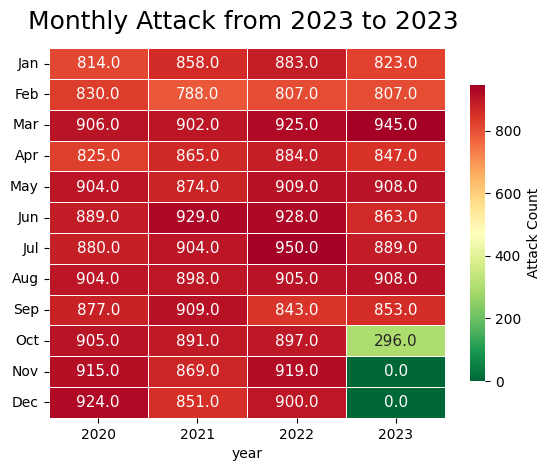

In [15]:
# display year vs months of 
ax = sns.heatmap(all_month_year_df, cmap='RdYlGn_r',
                 robust=True,
                 fmt='.1f',
                 annot=True,
                 linewidths=.5,
                 annot_kws={'size':11},
                 cbar_kws={'shrink':.8,
                           'label':'Attack Count'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.title('Monthly Attack from 2023 to 2023 ', fontdict={'fontsize':18},    pad=14)

Text(0.5, 1.0, 'Weekday total attack count 2020 to 2023')

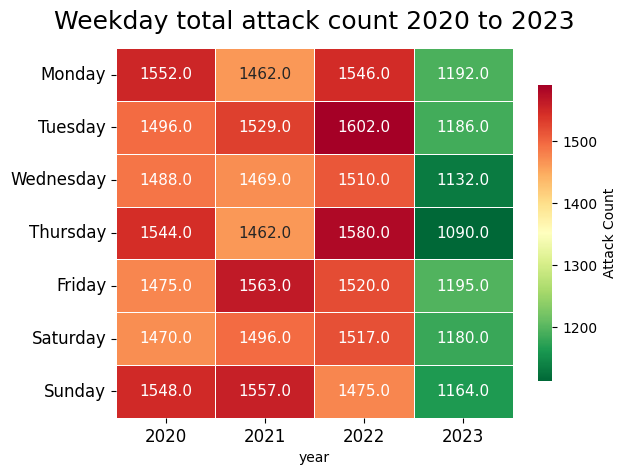

In [16]:
# generate pivot to show weekday vs year , each cell display attack count in a weekday whole year
weekdf_df = pd.pivot_table(df, values='Attack Type',
                                   index=["weekday"],
                                   columns=["year"],                                   
                                   aggfunc="count",                                   
                                   fill_value=0)
named_index_2 = [[calendar.day_name[i] if isinstance(i, int) else i for i in list(weekdf_df.index)]] # name months
weekdf_df = weekdf_df.set_index(named_index_2)
# Weekday total attack count in one year
ax = sns.heatmap(weekdf_df, cmap='RdYlGn_r',
                 robust=True,
                 fmt='.1f',
                 annot=True,
                 linewidths=.5,
                 annot_kws={'size':11},
                 cbar_kws={'shrink':.8,
                           'label':'Attack Count'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=12)
plt.title('Weekday total attack count 2020 to 2023', fontdict={'fontsize':18},    pad=14)